### Import required packages, set some settings

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

### Generate regression dataset

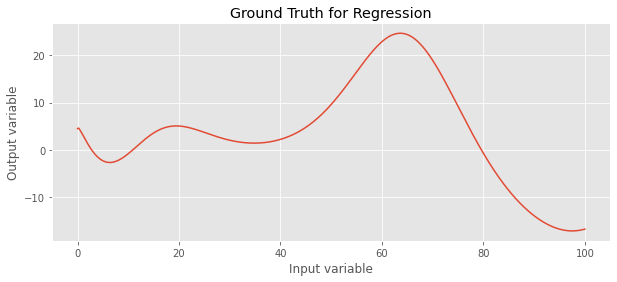

In [5]:
def ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.001*x+0.02)) + 3*np.exp(0.5*np.sin((x**0.9-3)/5))/((x+0.01)**(-0.5)) -0.005*x**2

xs = np.linspace(0, 100, 500)
ys = ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

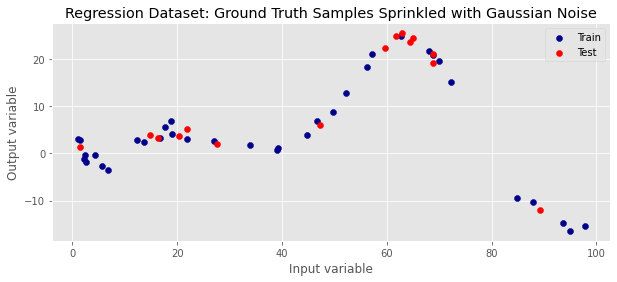

In [6]:
def generate_dataset(size=50, noise=1, split=0.3):
    xs = np.random.uniform(0, 100, size)
    ys = ground_truth(xs) + np.random.normal(0, noise, size)
    return train_test_split(xs, ys, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

### Control test: deterministic MLP

##### Build model

In [7]:
model = nn.Sequential(
    nn.Linear(1, 100),
    nn.ELU(),
    nn.Linear(100, 100),
    nn.ELU(),
    nn.Linear(100, 100),
    nn.ELU(),
    nn.Linear(100, 100),
    nn.ELU(),
    nn.Linear(100, 1),
)

loss = nn.MSELoss()
opt = torch.optim.SGD(
    model.parameters(), 
    lr=0.00005,  # learning rate
)

##### Train model

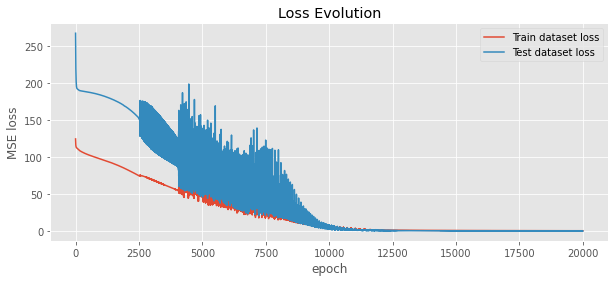

In [8]:
tr_loss_evo = []
te_loss_evo = []

for _ in range(20000):  # epochs
    y_tr_pred = model(x_tr)
    l = loss(y_tr_pred, y_tr)
    tr_loss_evo.append(l.item())
    te_loss_evo.append(loss(model(x_te), y_te).item())
    model.zero_grad()
    l.backward()
    opt.step()

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

##### Test model

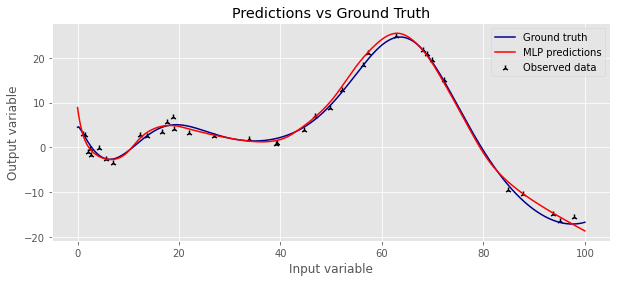

In [9]:
xs = np.linspace(0, 100, 500)
yps = model(torch.FloatTensor(xs).unsqueeze(-1)).detach().numpy()
ys = ground_truth(xs)
plt.title("Predictions vs Ground Truth")
plt.plot(xs, ys, color='darkblue', label='Ground truth')
plt.plot(xs, yps, color='red', label='MLP predictions')
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

### Bayesian neural network

##### Theory & assumptions

- The neural network is a function that returns an output given the input and the model parameters, $$\hat{y} = f(x, \boldsymbol{\theta})$$
- We assume (with i.i.d data) a Gaussian likelihood, $$\mathcal{L}(\boldsymbol{\theta}) = p(\mathcal{D}|\boldsymbol{\theta}) = \prod_n\mathcal{N}(y_n|f(x_n,\boldsymbol{\theta}), \sigma^2_{noise})$$ where $\sigma_{noise}$ is the variance parameter of the output neuron
- We take independent Gaussian priors over the parameters, $$p(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta}|\boldsymbol{0}, \sigma_p^2\mathbf{I})$$ where $\sigma_p$ is a variance hyperparameter
- Since the network function is highly nonlinear, the true posterior distribution is intractable and so we resort to variational inference. Namely, we resort to a mean-field (diagonal) Gaussian variational distribution: $$q_\phi(\boldsymbol{\theta}) = \prod_{i=1}^{|\boldsymbol{\theta}|}\mathcal{N}(\theta_i|\mu_i, \sigma_i^2)$$ where $\phi = \{\mu_i, \sigma_i\}$ are the variational parameters
- As usual in variational inference, we wish to select the variational parameters by minimising the Kullback-Leibler (KL) divergence between the variational distribution and the posterior, however as usual this too is intractable and so we optimise the evidence lower-bound (ELBO) instead, which can be written as: $$ELBO = \mathbb{E}_{\theta\sim q_{\phi}}[\log\mathcal{L}(\boldsymbol{\theta})] - KL[q_{\phi}||p(\boldsymbol{\theta})]$$ Looking at the two terms, we see that maximising the ELBO maximises the expected log likelihood (fit to the data) while minimising the KL divergence between the variational distribution and the prior distribution (the standard Bayesian "Occam's Razor" tradeoff)
- Since both the variational and prior distributions are taken to be Gaussian, the KL divergence between them can be calculated in closed form. Taking $k$ to denote the number of parameters, $$KL[q_{\phi}||p(\boldsymbol{\theta})] = \frac{1}{2}(\sum_i^k\frac{\mu_i^2 + \sigma_i^2}{\sigma_p^2} - 2\sum_i^k\log\frac{\sigma_i}{\sigma_p} - k)$$
- Thus the ELBO can be written as: $$ELBO = \mathbb{E}_{\theta\sim q_{\phi}}[\log\mathcal{L}(\boldsymbol{\theta})] - \frac{1}{2}\sum_i^k[\frac{\mu_i^2 + \sigma_i^2}{\sigma_p^2} - 2\log\frac{\sigma_i}{\sigma_p} - 1]$$ where we can estimate the first term by sampling and using the *reparameterisation trick* (Kingma and Welling, 2014)

##### Build model

In [40]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.mu_p = torch.zeros(input_dim, output_dim)
        self.log_var_p = torch.zeros(input_dim, output_dim)

        # Variational parameters q(theta)
        self.mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )   # why this initialisation?

    # @property
    def prior(self):
        return torch.distributions.Normal(self.mu_p, (0.5 * self.log_var_p).exp())

    # @property
    def posterior(self):
        return torch.distributions.Normal(self.mu_q, (0.5 * self.log_var_q).exp())

    def kl(self):
        return torch.distributions.kl.kl_divergence(self.posterior(), self.prior())

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior.

        Args:
            x (torch.Tensor): Inputs to this layer.

        Returns:
            torch.Tensor: Outputs of this layer.
        """
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us
        weights = self.posterior().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        return x @ weights  # (num_samples, batch_size, output_dim).








class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU,
        noise_std=1.0
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.noise_std = noise_std

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation())
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation())

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)

        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, self.noise_std)
        return l.log_prob(y_obs.unsqueeze(1)).mean(1).sum(0)  # will probably need to fix these dims

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if layer == MeanFieldLayer])

    def loss(self, y_pred, y):
        """Computes the ELBO and returns its negative"""
        
        exp_ll = self.ll(y, y_pred)
        kl = self.kl()

        return kl - exp_ll

In [54]:
bnn_model = MeanFieldBNN(1, [100, 100, 100, 100], 1)
print(bnn_model)

opt = torch.optim.SGD(
    bnn_model.parameters(),
    lr = 0.0005
)

MeanFieldBNN(
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
    (5): ELU(alpha=1.0)
    (6): MeanFieldLayer()
    (7): ELU(alpha=1.0)
    (8): MeanFieldLayer()
  )
)


##### Train model

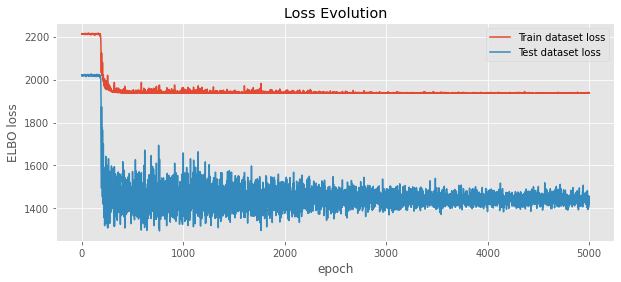

In [55]:
tr_loss_evo = []
te_loss_evo = []

for _ in range(5000):  # epochs
    bnn_model.zero_grad()

    y_tr_pred = bnn_model(x_tr)
    l = bnn_model.loss(y_tr_pred, y_tr)
    tr_loss_evo.append(l.item())

    y_te_pred = bnn_model(x_te)
    te_loss_evo.append(bnn_model.loss(y_te_pred, y_te).item())

    l.backward()
    opt.step()

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

##### Test model

In [ ]:
# xs = np.linspace(0, 100, 500)
# sample_pred = bnn_model(torch.FloatTensor(xs).unsqueeze(-1))
# mu, logvar = mu.detach().numpy(), logvar.detach().numpy()
# ys = ground_truth(xs)
# plt.title("Predictions vs Ground Truth")
# plt.plot(xs, ys, color='darkblue', label='Ground truth')
# plt.plot(xs, mu, color='red', label='BNN mean predictions')
# plt.plot(xs, mu + np.sqrt(np.exp(logvar)), color='darkorange', label='1 std above BNN mean predictions')
# plt.plot(xs, mu - np.sqrt(np.exp(logvar)), color='darkorange', label='1 std below BNN mean predictions')
# plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2')
# plt.xlabel('Input variable')
# plt.ylabel('Output variable')
# plt.legend()
# plt.show()